In [1]:
import numpy as np
import geopandas as gpd
import os
import pandas as pd
from scipy import stats as scipy_stats
from scipy.signal import convolve2d
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import Polygon

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

Much of this notebook comes from: https://www.youtube.com/watch?v=VIr-pejky6E

## Bring in raster data

In [2]:
S3R = S3Reader('roof-index')
dsm_path = "/missoula/geospatial/downtown_slope.tif" 
dsm = S3R.get_tif_from_s3_as_rio(dsm_path) 
dsm.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 1571,
 'height': 1645,
 'count': 1,
 'crs': CRS.from_epsg(6514),
 'transform': Affine(0.9144000000087544, 0.0, 257075.3304003399,
        0.0, -0.9144000000087544, 301627.6416007468)}

## Define Hyperparameters

In [3]:
# Maximum slope (in degrees) value at which we consider a rooftop to be 'flat'
slope_threshold = 5

# Minimum percentage of flat area on a roof for the roof to be classified as 'flat'
area_threshold = 5

## Bring in vector data

In [4]:
bldgs_path = "/missoula/geospatial/downtown_bldgs.zip"
bldgs = S3R.get_shp_from_s3_as_gpd(bldgs_path).to_crs(6514)
bldgs

,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,geometry
0,1.0,27.32460,3202.73,44334.900,MULTIPOLYGON Z (((257091.482 300124.221 27.325...
1,2.0,11.80030,3204.72,5449.480,"POLYGON Z ((257170.740 300266.436 11.800, 2571..."
2,3.0,11.44360,3205.74,3658.490,"POLYGON Z ((257170.172 300185.933 11.444, 2571..."
3,4.0,30.45860,3205.99,13970.200,MULTIPOLYGON Z (((257408.449 300123.800 30.459...
4,5.0,10.99220,3204.42,6748.850,"POLYGON Z ((257175.485 300291.266 10.992, 2571..."
...,...,...,...,...,...
958,959.0,10.41030,3217.27,566.998,"POLYGON Z ((258263.976 301156.751 10.410, 2582..."
959,960.0,17.13810,3214.29,2976.740,"POLYGON Z ((258224.819 301179.597 17.138, 2582..."
960,961.0,16.08160,3217.24,1456.870,"POLYGON Z ((258300.759 301228.699 16.082, 2582..."
961,962.0,9.34612,3216.50,272.249,"POLYGON Z ((258217.425 301179.456 9.346, 25822..."


## Plot buildings and slope

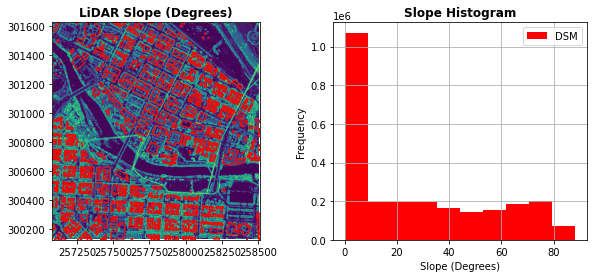

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
show(dsm, ax = ax1, title= 'LiDAR Slope (Degrees)')
bldgs.plot(ax = ax1, facecolor='None', edgecolor='red')
show_hist(dsm, title='Slope Histogram', ax=ax2, label='DSM')
ax2.set_xlabel('Slope (Degrees)')
plt.show()

## Determine Roof Pitch

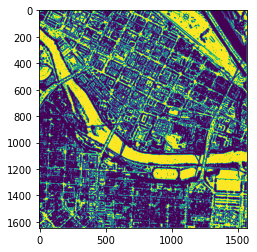

In [6]:
# Assign raster values to a numpy array
dsm_arr = dsm.read(1)

affine = dsm.transform

slope_arr = np.where(dsm_arr > slope_threshold, 0, 1)
# kernel = np.ones((3, 3))
# filled = convolve2d(dsm_arr, kernel, mode='full', boundary='fill', fillvalue=0)
# filled = np.where(filled < 2, 0, 1)

plt.imshow(slope_arr)

# If a pixel's slope is greater than 5 degrees, assign a 0, otherwise assign a 1. 
# Then sum the pixels and calculate area.
def flat_area(x):

    flat_count = np.sum(x)
    
    return flat_count * affine[0] * -affine[4]

# Calculate zonal statistics
zstats = rasterstats.zonal_stats(bldgs, slope_arr, affine=affine,
    nodata=dsm.nodata, geojson_out=True, add_stats={'flat_area': flat_area})

## Add flat area to geopandas dataframe

In [7]:
# Extract flat area from stats
fa = []
for bldg_stats in zstats:
    bldg_fa = (bldg_stats['properties']['fid'], bldg_stats['properties']['flat_area']*3.28084)
    fa.append(bldg_fa)

fa_df = gpd.GeoDataFrame(fa, columns=['fid', 'fa_sq_ft'])
full_data = pd.merge(bldgs, fa_df)

In [8]:
# Reorder columns 
cols = full_data.columns.tolist()
cols.insert(4, cols[-1])
full_data = full_data[cols[:-1]]

In [9]:
# Fix datatype issue
full_data = full_data.astype({'fa_sq_ft': np.float64}, copy=True)
full_data['fa_perc'] = (full_data['fa_sq_ft'] / full_data['area_sq_ft']) * 100
full_data

/opt/miniconda3/envs/ds/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1097: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


,fid,AVG_HEIGHT,MIN_LAG,area_sq_ft,fa_sq_ft,geometry,fa_perc
0,1.0,27.32460,3202.73,44334.900,1626.717652,MULTIPOLYGON Z (((257091.482 300124.221 27.325...,3.669158
1,2.0,11.80030,3204.72,5449.480,128.930404,"POLYGON Z ((257170.740 300266.436 11.800, 2571...",2.365921
2,3.0,11.44360,3205.74,3658.490,19.202401,"POLYGON Z ((257170.172 300185.933 11.444, 2571...",0.524872
3,4.0,30.45860,3205.99,13970.200,405.993613,MULTIPOLYGON Z (((257408.449 300123.800 30.459...,2.906140
4,5.0,10.99220,3204.42,6748.850,323.697610,"POLYGON Z ((257175.485 300291.266 10.992, 2571...",4.796337
...,...,...,...,...,...,...,...
958,959.0,10.41030,3217.27,566.998,5.486400,"POLYGON Z ((258263.976 301156.751 10.410, 2582...",0.967622
959,960.0,17.13810,3214.29,2976.740,30.175201,"POLYGON Z ((258224.819 301179.597 17.138, 2582...",1.013700
960,961.0,16.08160,3217.24,1456.870,10.972800,"POLYGON Z ((258300.759 301228.699 16.082, 2582...",0.753176
961,962.0,9.34612,3216.50,272.249,0.000000,"POLYGON Z ((258217.425 301179.456 9.346, 25822...",0.000000


## Add whether or not rooftop is flat to dataframe

In [10]:
# In this case, it looks like specifying a slope threshold of 15 degrees and an area threshold of 15% does
# a good job filtering out resedential buildings and picking up larger commercial buildings. 
full_data['flat'] = (full_data.fa_perc > area_threshold)

## Plot flat buildings

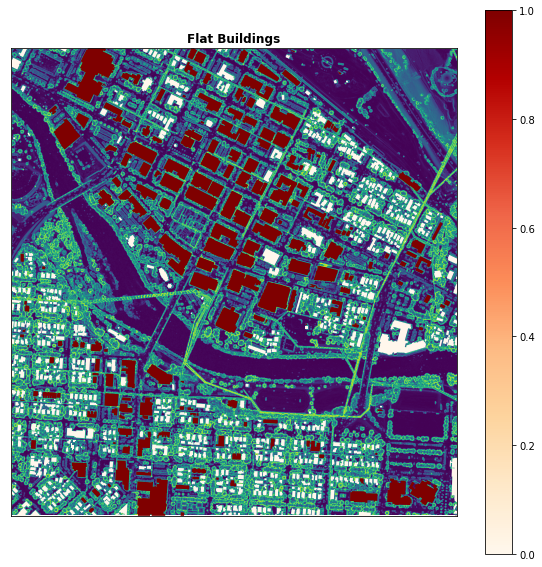

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
show(dsm, ax = ax, title= 'Flat Buildings')
full_data.plot(column='flat', legend=True, ax=ax, cmap='OrRd')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.show()

## Write to shapefile

In [61]:
# full_data.to_file("../missoula_data/downtown_bldgs_flat.shp")